# Khai báo các thư viện và thực hiện các setup cần thiết

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import datetime
from os import listdir
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Trực quan trên dữ liệu của một ngày

Xét dữ liệu ngày 03-03-2022

In [2]:
check_df = pd.read_csv('./data/03-03-2023.csv')
check_df.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent
0,World,680537958,102399,6804648,614,653341850,145174,20391460,87307,873,0,0,0,All
1,USA,105392498,8481,1146723,93,102846371,56219,1399404,314787,3425,1167591546,3487375,334805269,North America
2,India,44687496,334,530775,3,44154035,170,2686,31769,377,918992653,653329,1406631776,Asia
3,France,39634146,3194,165030,21,39397305,3166,71811,604322,2516,271490188,4139547,65584518,Europe
4,Germany,38210850,8279,168397,101,37742800,13200,299653,455522,2008,122332384,1458359,83883596,Europe


Xem xét 10 quốc gia có số lượng ca nhiễm nhiều nhất trên thế giới.  
Để có thể trực quan, ta sẽ lọc ra 10 quốc gia có số lượng ca nhiễm nhiều nhất thế giới, hạng 1 ở đây sẽ là `World` tức là thế giới nên ta sẽ lấy từ hạng 2 đến hạng 11.

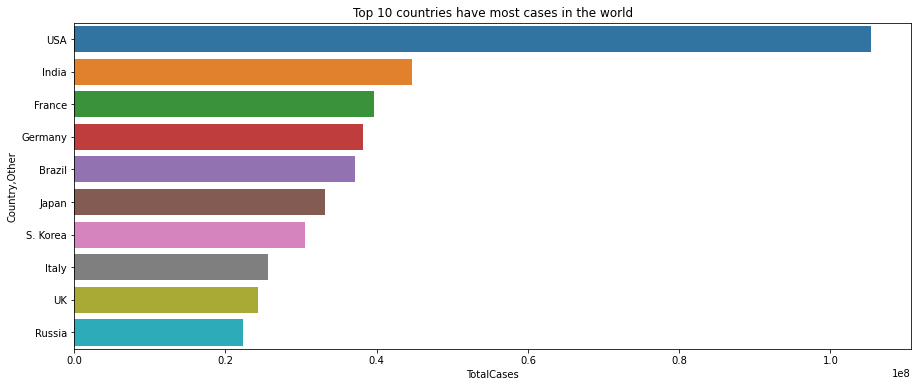

In [3]:
#Filter top 10 countries have most cases in the world
top_10_case_df = check_df.sort_values(by=['TotalCases'], ascending=False).iloc[1:11]

#Plotting
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=top_10_case_df, y='Country,Other', x='TotalCases')
ax.set(title='Top 10 countries have most cases in the world');

Ta có thể thấy `Mỹ` có nhiều ca nhất trên thế giới với hơn 100 triệu ca trong khi các nước còn lại chỉ khoảng dưới 50 triệu ca!  
Nhưng liệu với số lượng ca nhiễm khổng lồ này, `Mỹ` có phải là quốc gia có tốc độ lây lan nhanh nhất trên thế giới không?  
Ta sẽ trực quan điều này qua thuộc tính `Tot Cases/1M pop` với ý nghĩa là tổng số ca nhiễm trên 1 triệu dân.

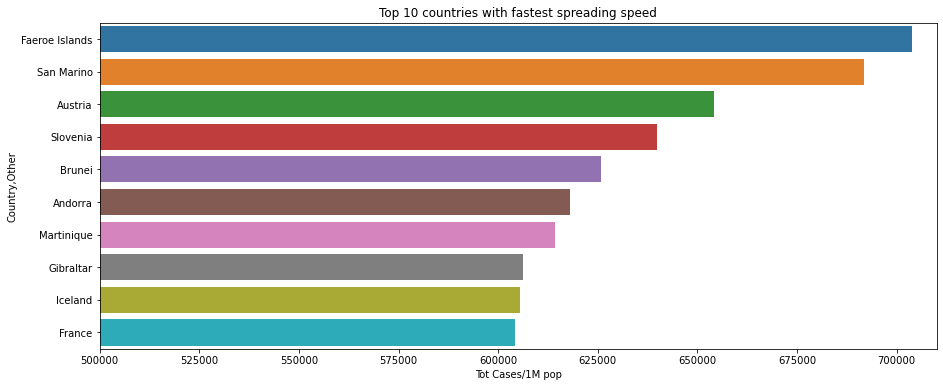

In [4]:
#Filter top 10 countries have most 'Tot Cases/1M pop' in the world
top_10_speed_df = check_df.sort_values(by=['Tot Cases/1M pop'], ascending=False).iloc[:10]

#Plotting
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=top_10_speed_df, y='Country,Other', x='Tot Cases/1M pop')
ax.set_xlim(500000, 710000)
ax.set(title='Top 10 countries with fastest spreading speed');

Như vậy, tình hình ở `Faeroe Islands` là nghiêm trọng nhất vì tốc độ lây lan rất cao!  
Thế những quốc gia có tốc độ lây lan chậm nhất (tình hình ổn nhất) là đâu?

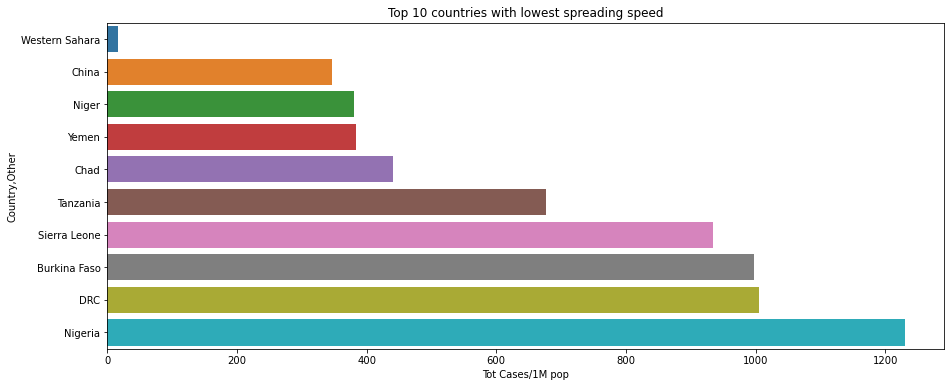

In [5]:
#Filter top 10 countries have least 'Tot Cases/1M pop' in the world (except countries that have nan value)
top_10_lowest_speed_df = check_df[check_df['Tot Cases/1M pop'] != 0]
top_10_lowest_speed_df = top_10_lowest_speed_df.sort_values(by=['Tot Cases/1M pop']).iloc[:10]

#Plotting
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=top_10_lowest_speed_df, y='Country,Other', x='Tot Cases/1M pop')
ax.set(title='Top 10 countries with lowest spreading speed');

Có thể nói tình hình dịch bẹnh ở khu vực `Weatern Sahara` là ổn định nhất vì tốc độ lây lan là chậm nhất!

Qua 4 năm 2019-2022, tình hình dịch bệnh đã có tiến triển tốt, các ca phục hồi đã tăng lên. Như vậy, khu vực hay quốc gia nào có tỉ lệ phục hồi cao nhất?  
Ta trực quan điều này bằng cách chia thuộc tính `TotalRecovered` cho thuộc tính `TotalCases` để có được tỉ lệ hồi phục, sau đó lọc ra top 10 nước có tỉ lệ hồi phục cao nhất trên thế giới, bên cạnh đó so sánh với tỉ lệ hồi phục trung bình trên toàn thế giới.

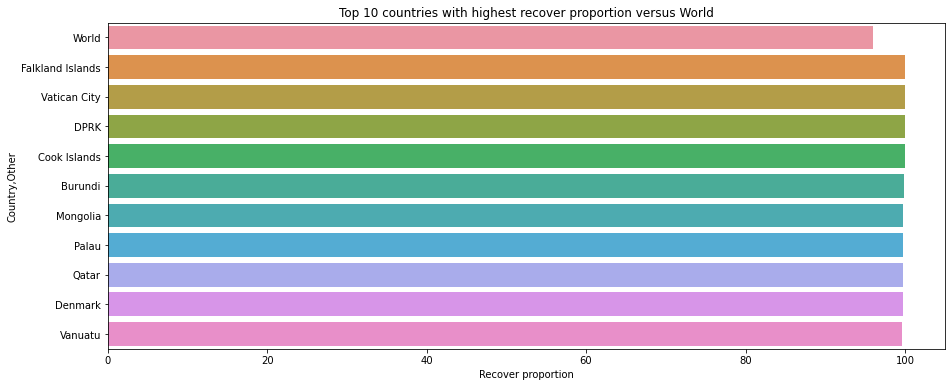

In [6]:
# Get and process 'World' only
world_df = check_df.iloc[0,:]
world_df = world_df.to_frame().T
world_df['Recover proportion'] = world_df['TotalRecovered'].astype(float) / world_df['TotalCases'].astype(float) * 100

# Filter top 10 countries have highest 'Recover proportion' in the world
top_10_recover_df = check_df[check_df['TotalCases'] != 0]
top_10_recover_df['Recover proportion'] = top_10_recover_df['TotalRecovered'].astype(float) / top_10_recover_df['TotalCases'].astype(float) * 100
top_10_recover_df = top_10_recover_df.sort_values(by=['Recover proportion'], ascending=False).iloc[:10]

# Merge 2 dataframe
top_10_recover_df = pd.concat([world_df, top_10_recover_df])

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=top_10_recover_df, y='Country,Other', x='Recover proportion')
ax.set(title='Top 10 countries with highest recover proportion versus World');

Có thể thấy những nước có tỉ lệ hồi phục cao nhất đều cao hơn so với trung bình trên thế giới, vậy những nước lớn (nước có dân số lớn) thì sao?  
Ta làm tương tự như trên nhưng sẽ lọc ra 10 nước có lượng dân số lớn nhất thay vì tỉ lệ hồi phục cao nhất!

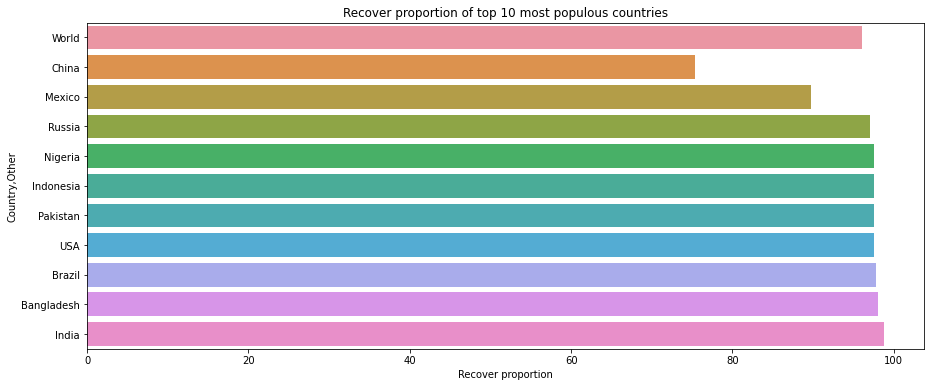

In [7]:
# Get and process 'World' only
world_df = check_df.iloc[0,:]
world_df = world_df.to_frame().T
world_df['Recover proportion'] = world_df['TotalRecovered'].astype(float) / world_df['TotalCases'].astype(float) * 100

# Filter top 10 countries have highest 'Recover proportion' in the world
top_10_population_df = check_df[check_df['TotalCases'] != 0]
top_10_population_df['Recover proportion'] = top_10_population_df['TotalRecovered'].astype(float) / top_10_population_df['TotalCases'].astype(float) * 100
top_10_population_df = top_10_population_df.sort_values(by=['Population'], ascending=False).iloc[:10]
top_10_population_df = top_10_population_df.sort_values(by=['Recover proportion'])

# Merge 2 dataframe
top_10_population_df = pd.concat([world_df, top_10_population_df])

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=top_10_population_df, y='Country,Other', x='Recover proportion')
ax.set(title='Recover proportion of top 10 most populous countries');

Ngoại trừ `Trung Quốc` và `Mexico`, các nước lớn còn lại đều có tỉ lệ hồi phục cao hơn trung bình trên thế giới!

Nhìn rộng một chút, liệu số lượng ca nhiễm mới có tỉ lệ với số lượng ca chết không? Ta sẽ trực quan bằng cách đưa lên lấy ra 2 thuộc tính `NewCases` và `NewDeaths` sau đó đưa lên biểu đồ scatter plot

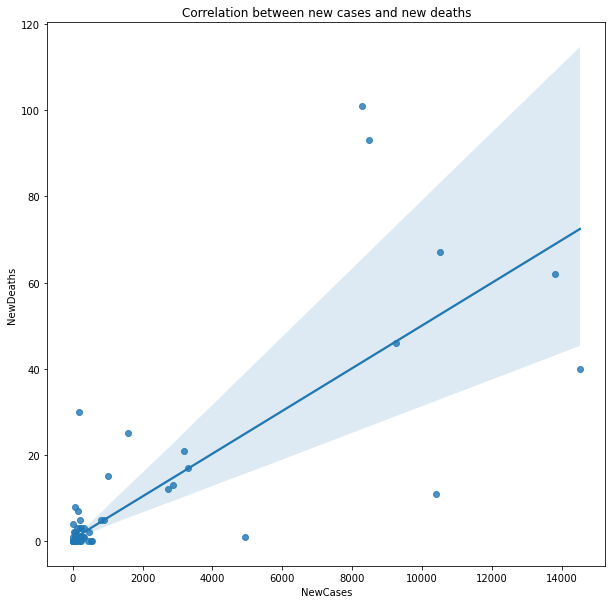

In [8]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(data=check_df.iloc[1:], x='NewCases', y='NewDeaths')
ax.set(title='Correlation between new cases and new deaths');

Từ đồ thị ta có thể thấy tỉ lệ thuận ở số ca nhiễm mới với số ca chết mới. Điều này hợp lí vì càng nhiều ca nhiễm thì lượng ca chết sẽ tăng!

# Trực quan trên dữ liệu của nhiều ngày

Lấy dữ liệu ở nhiều ngày sau đó lưu vào dictionary

In [9]:
files = [f for f in listdir('./data/')]

df_dict = {}

for file in files:
    url = './data/' + file
    df_dict[file[:-4]] = pd.read_csv(url)

Đã qua nhiều năm kể từ lúc bắt đầu bùng dịch cũng như lúc dịch bệnh cao trào, liệu có sự giảm trong tình hình dịch bệnh hay không, ta sẽ kiểm tra bằng tốc độ lây lan (thuộc tính `Tot Cases/1M pop`) của 9 nước đông dân nhất thế giới.

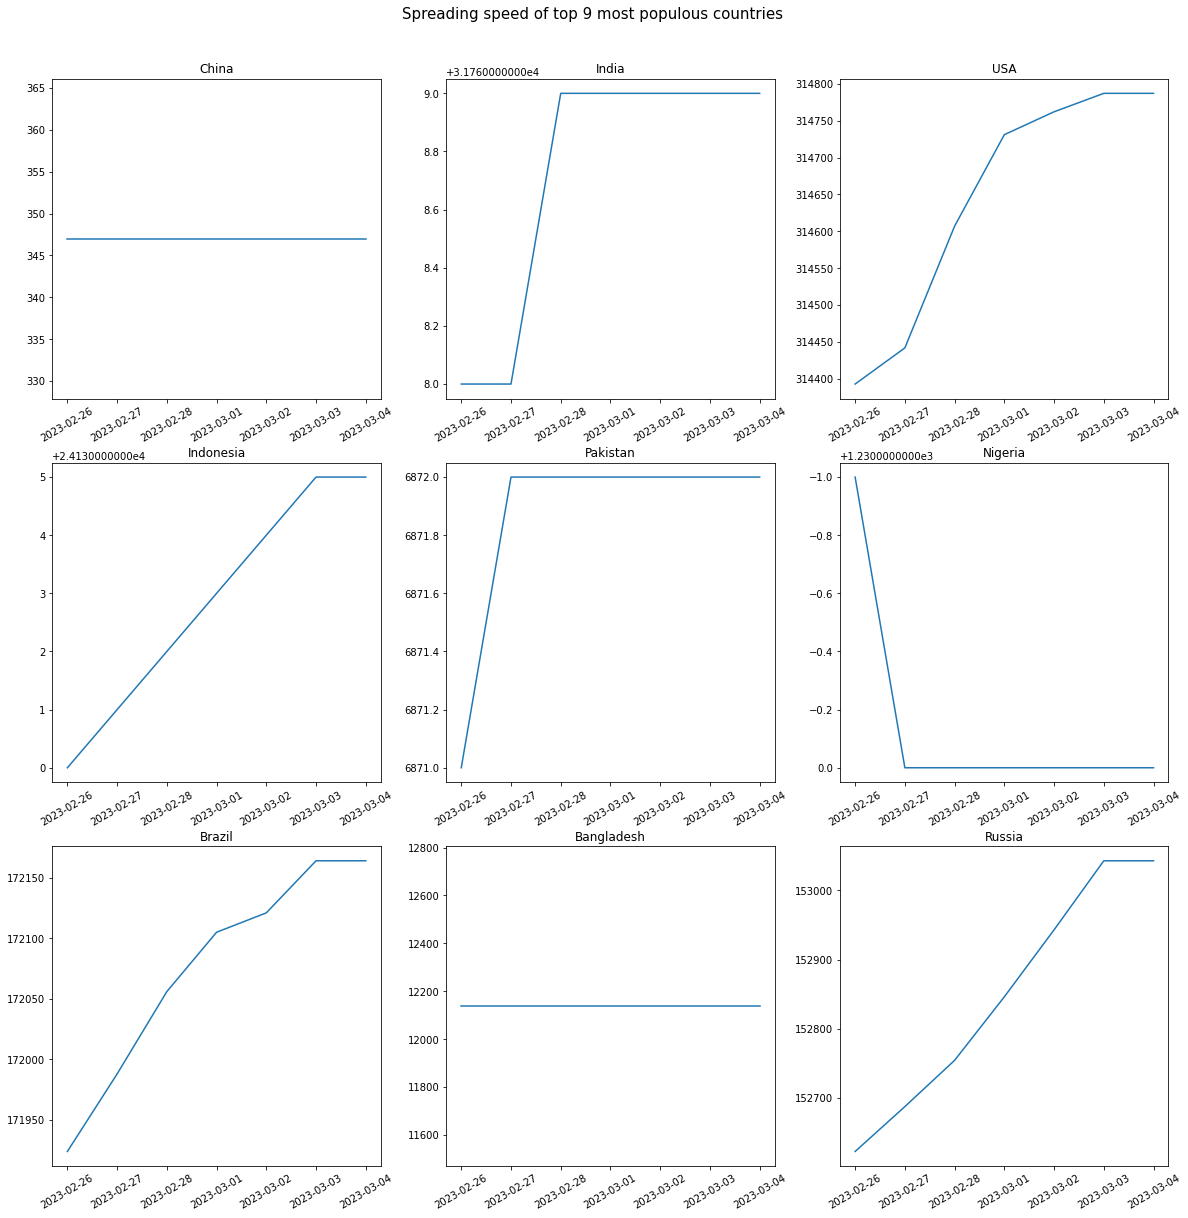

In [23]:
# Get list of top 9 countries with the most population
country_list = list(df_dict.values())[0].sort_values(by=['Population'], ascending=False).iloc[:9]['Country,Other'].to_list()

# Get 'Tot Cases/1M pop' attribute from 9 countries day by day
date_list = []
data_list = []
for key, item in df_dict.items():
    date_list.append(key)
    temp = item.set_index('Country,Other')
    data_list.append(temp['Tot Cases/1M pop'][country_list].to_list())

spread_speed_df = pd.DataFrame(data=data_list,columns=country_list,index=date_list)
spread_speed_df.index = pd.to_datetime(spread_speed_df.index, format="%d-%m-%Y")
spread_speed_df = spread_speed_df.sort_index()

# Plotting
nth = 0
fig, ax = plt.subplots(figsize=(20,20), nrows=3, ncols=3)
for row in ax:
    for col in row:
        sns.lineplot(data=spread_speed_df[country_list[nth]], ax=col)
        plt.sca(col)
        plt.xticks(rotation=30)
        col.set_ylabel('')
        col.set(title=country_list[nth])
        if country_list[nth] == 'Nigeria':
            col.invert_yaxis()
        nth += 1
fig.suptitle('Spreading speed of top 9 most populous countries', y=0.93, fontsize=15);

Có đường nằm ngang ở 2 nước `Trung Quốc` và `Bangladesh` cùng với xu hướng giảm ở `Nigeria`, có vẻ như dịch đã không còn lây lan ở 3 nước này nhưng ở các nước còn lại vẫn đang có xu hướng tăng đặc biệt là `Mỹ`, `Indonesia`, `Brazil` và `Nga` đang có xu hướng tăng tuyến tính.  
Vậy ở các nước đang có số lượng ca mới tăng nhiều thì sao? Ta sẽ kiểm chứng bằng cách lấy một ngày trong quá khứ (để số liệu được ổn định), lọc ra 10 nước có thêm nhiều ca mới nhất sau đó xem xét tình hình 10 nước đó trên biểu đồ. Vì ở đây số liệu của `World` là tổng các nước nên sẽ loại `World` ra. Bên cạnh đó số liệu của ngày hôm nay có thể chưa được cập nhật nên sẽ loại ngày hôm nay ra khỏi biểu đồ.

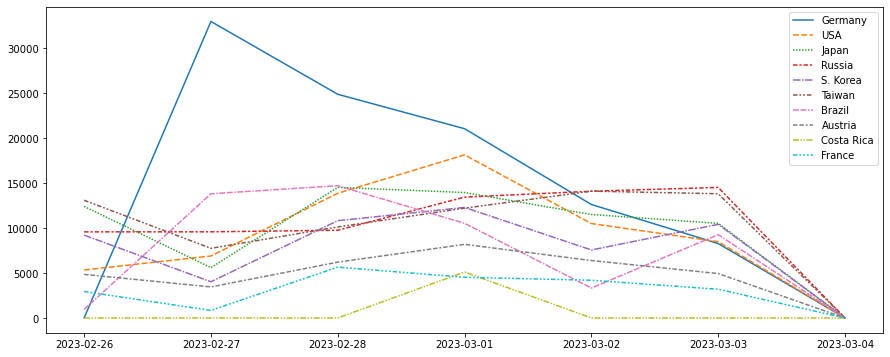

In [24]:
# Get list of top 10 countries with the cases
country_list = list(df_dict.values())[0].sort_values(by=['NewCases'], ascending=False).iloc[1:11]['Country,Other'].to_list()

# Get 'NewCases' attribute from 10 countries day by day
date_list = []
data_list = []
for key, item in df_dict.items():
    date_list.append(key)
    temp = item.set_index('Country,Other')
    data_list.append(temp['NewCases'][country_list].to_list())

new_cases_df = pd.DataFrame(data=data_list,columns=country_list,index=date_list)
new_cases_df.index = pd.to_datetime(new_cases_df.index, format="%d-%m-%Y")
new_cases_df.sort_index()
new_cases_df = new_cases_df[new_cases_df.index != pd.to_datetime(datetime.date.today())]

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=new_cases_df);

Có vẻ như ở `Đức` vừa có một đợt bùng dịch lớn với số ca nhiễm mới ngày 26 gần như bằng 0 nhưng lại tăng đột biến vào ngày hôm sau. Tuy nhiên, dịch đang được kiểm soát khá tốt khi số ca nhiễm có xu hướng giảm rất nhanh. Bên cạnh đó, một vài nước đang có xu hướng tăng số ca nhiễm như `Nga`, `Hàn Quốc` và `Brazil`